### IMPORT DI VARIE LIBRERIE
- pandas per l'elaborazione di dati sotto forma di dataframe
- numpy per l'elaborazione di dati sotto forma di array
- matplotlib per la stampa di grafici
- sklearn per modelli di machine learning, strumenti di preprocessing e acquisizione performance

In [1]:
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import math
from sklearn.ensemble import VotingClassifier


plt.rcParams["figure.figsize"] = (12,6)

### DEFINIZIONE DI FUNZIONI DI SUPPORTO
- **recuperaPerformance(y_test, y_pred)**<br>
ritorna i valori di TP, FP, FN, TN a considerando le predizioni ottenute rispetto a quelle vere<br>
<br>

- **plotPerformance(scores)**<br>
stampa grafici relativi alle performance di vari classificatori<br>
score è una lista di liste [ _[Precision, Recall, F1-Score, Accuracy, Specificity]_, ... ]<br>
<br>

- **fitnessFunction(moth_pos, x_train, y_train, x_test, y_test, classificatore)**<br>
ritorna il valore della la funzione di fitness di _classificatore_ sulla base delle informazioni contenute in _moth_pos_<br>
<br>

- **mfo(x_train, y_train, x_test, y_test, Max_iteration, classificatore)**<br>
effettua una feature selection per il _classificatore_ applicando l'algoritmo Moth-flame optimization

In [2]:
def recuperaPerformance(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)    
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    
    return tp, fp, fn, tn

In [3]:
def plotPerformance(scores):
    labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Specificity']
    DT_value = scores[0]
    NB_value = scores[1]
    RF_value = scores[2]
    SVM_value = scores[3]


    x = np.arange(len(labels))
    width = 0.20

    fig, ax = plt.subplots()
    rectsDT = ax.bar(x - width, DT_value, width, label='DT',color='#7F7F7F')
    rectsNB = ax.bar(x, NB_value, width, label='NB', color='#FE9900')
    rectsRF = ax.bar(x + width, RF_value, width, label='RF',color='#77933C')
    rectsSVM = ax.bar(x + 2*width, SVM_value, width, label='SVM',color='#4F81BC')

    ax.set_ylabel('Misure %')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rectsDT, padding=3, rotation=90)
    ax.bar_label(rectsNB, padding=3, rotation=90)
    ax.bar_label(rectsRF, padding=3, rotation=90)
    ax.bar_label(rectsSVM, padding=3, rotation=90)

    fig.tight_layout()
    plt.legend(loc=(1.04,0))

    plt.show()

In [4]:
def fitnessFunction(moth_pos, x_train, y_train, x_test, y_test, classificatore): 
    x_train_selected_features=pd.DataFrame()
    x_test_selected_features=pd.DataFrame()


    for i in range(len(moth_pos)):
        x_train_selected_features[str(moth_pos[i])] = x_train.iloc[:,int(moth_pos[i])]
        x_test_selected_features[str(moth_pos[i])] = x_test.iloc[:,int(moth_pos[i])]
        
    classificatore.fit(x_train_selected_features, y_train)
    y_test=y_test.to_numpy()
    y_pred = classificatore.predict(x_test_selected_features)

    tp, fp, fn, tn = recuperaPerformance(_y_test, y_pred)
    
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    return (tp+tn)/(tn+fp+fn+tp)

In [5]:
def mfo(x_train, y_train, x_test, y_test, Max_iteration, classificatore):
    # crea una popolazione di n falene d-dimensionali    
    n = 20
    d = len(x_train.iloc[0])
    M = np.zeros(shape=(n,d))
    
    # posiziona le falene in modo random
    for i in range(n):
        M[i]=np.random.randint(d, size=d)
    
    # inizialmente il vettore del valore di fitness per ogni falena è pari a zero
    # M[i] indica il valore di fitness della falena i
    OM = np.zeros(n)
    
    previous_population=0
    previous_fitness=0
    
    
    for l in range(1,Max_iteration+1):
        # aggiorna il numero di falene
        number_of_flames = round(n-l*((n-1)/Max_iteration));
        
        # calcola il valore di fitness per ogni falena
        for i in range(20):
            OM[i] = fitnessFunction(M[i],x_train, y_train, x_test, y_test, classificatore)
        
        # se è la prima iterazione allora il miglior fitness si ottiene semplicemente ordinando
        # in modo decrescente il vettore del valore di fitness e acquisendo l'indice della falena corrispondente
        if l==1:
            best_flame_fitness = np.sort(OM)[::-1] 
            I = np.argsort(OM)[::-1]
            best_flames = M[I]
        # se non è la prima iterazione allora il miglior fitness si ottiene considerando
        # il vettore del valore di fitness dell'iterazione corrente e passata
        else:
            double_population = np.concatenate((previous_population,best_flames))
            double_fitness = np.concatenate((previous_fitness, best_flame_fitness))
            
            double_fitness_sorted = np.sort(double_fitness)[::-1]
            I=np.argsort(double_fitness)[::-1]
            double_sorted_population = double_population[I]
            
            best_flame_fitness = double_fitness_sorted[0:n]
            best_flames = double_sorted_population[0:n]
        
        # aggiorna la lo stato della popolazione delle fale e vettore del valore di fitness precedente
        previous_population=M
        previous_fitness=OM
        
        # aggiorna la posizione di ogni falena che ruota intorno alle migliori fiamme
        # il movimento a spirale è modellato con una funzione coseno che dipende dal parametro t che decresce
        # linearmente da -1 fino a -2
        t =-1 - l*(1/Max_iteration);   
        for i in range(n):
            for j in range(d):
                distance_moth_flame = abs(best_flames[i][j] - M[i][j])
                b = 1
                
                if i<=number_of_flames:
                    M[i][j] = round(distance_moth_flame*math.exp(b*t)*math.cos(t*2*math.pi) + best_flames[i][j])
                    
                else:
                    M[i][j] = round(distance_moth_flame*math.exp(b*t)*math.cos(t*2*math.pi) + best_flames[number_of_flames][j])
                    
                #se la falena è uscita dallo spazio di ricerca, riportala all'interno di esso
                if M[i][j]<0:
                    M[i][j]=0

                if M[i][j]>d-1:
                    M[i][j]=d-1
    return best_flames[1]

### ANALISI DATASET

In [6]:
raw_data = loadarff('messidor_features.arff')
df = pd.DataFrame(raw_data[0])
df['Class']=df['Class'].str.decode("utf-8")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,0
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,0
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,1
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,0
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1.0,1.0,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0.0,0
1147,1.0,1.0,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0.0,0
1148,1.0,0.0,49.0,48.0,48.0,45.0,43.0,33.0,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0.0,0
1149,1.0,1.0,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1.0,1


In [7]:
df.dtypes

0        float64
1        float64
2        float64
3        float64
4        float64
5        float64
6        float64
7        float64
8        float64
9        float64
10       float64
11       float64
12       float64
13       float64
14       float64
15       float64
16       float64
17       float64
18       float64
Class     object
dtype: object

In [8]:
for col in df:
    print(col + " " + str(len(df[col].unique())))

0 2
1 2
2 110
3 104
4 99
5 91
6 84
7 69
8 1141
9 1141
10 1130
11 1032
12 795
13 579
14 415
15 351
16 1132
17 1110
18 2
Class 2


### DIVISIONE TRAINING SET E TEST SET E DEFINIZIONE DEI CLASSIFICATORI USATI
(in proporzione **Training Set: 80%** e **Test Set_: 20%**)

- DECISION TREE
- NAIVE BAYES
- RANDOM FOREST
- SUPPORT VECTOR MACHINE

In [9]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_y_test=y_test.to_numpy()

decisionTree = DecisionTreeClassifier()
naiveBayes = GaussianNB()
randomForest = RandomForestClassifier(n_estimators=100)
supportVectorMachine = svm.SVC(kernel='linear')
classifiers=[decisionTree, naiveBayes, randomForest, supportVectorMachine]

### TEST PERFORMANCE SENZA ELABORAZIONI

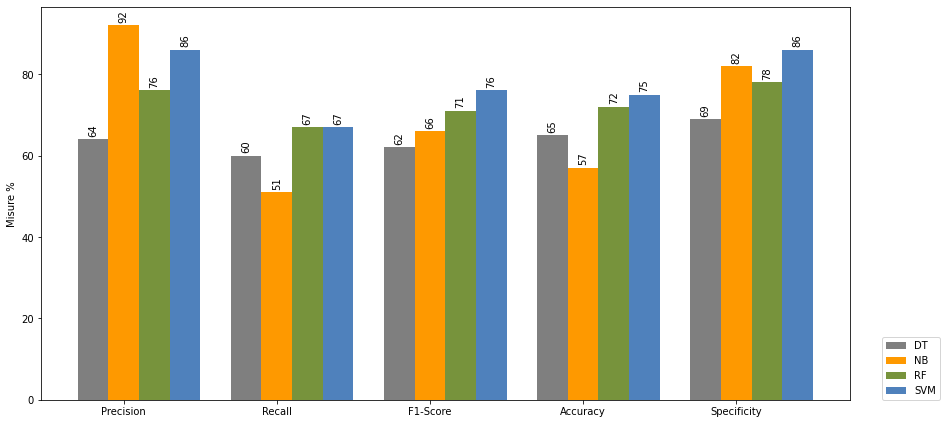

In [10]:
scores = []

for classificatore in classifiers:
    classificatore.fit(X_train, y_train)
    y_pred = classificatore.predict(X_test)

    tp, fp, fn, tn = recuperaPerformance(_y_test, y_pred)
    
    score = []
    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    f1 = (2*precision*recall)/(precision+recall)
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    specifity = tn/(fp+tn)
    
    score.append(round(precision,2)*100)
    score.append(round(recall,2)*100)
    score.append(round(f1,2)*100)
    score.append(round(accuracy,2)*100)
    score.append(round(specifity,2)*100)
    
    scores.append(score)

plotPerformance(scores)

### PRE-PROCESSING
- StandardScaler
- PCA

In [11]:
#Scaler
standard_scaler = StandardScaler().fit(X_train)

train_x_scaled = standard_scaler.transform(X_train)
test_x_scaled = standard_scaler.transform(X_test)


train_x_scaled = pd.DataFrame(train_x_scaled)
test_x_scaled = pd.DataFrame(test_x_scaled)

train_x_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.057197,0.295754,0.148975,0.179426,0.221844,0.231373,0.276623,0.065237,-0.590322,-0.523303,-0.647006,-0.449649,-0.216202,-0.190810,-0.202394,-0.198586,-0.393843,1.739682,-0.721569
1,0.057197,0.295754,-1.376054,-1.398621,-1.402151,-1.380870,-1.313640,-1.190647,0.597973,-0.668580,-0.567478,-0.442984,-0.216202,-0.190810,-0.202394,-0.198586,-0.681009,1.073527,1.385870
2,0.057197,0.295754,4.020202,3.875378,3.294267,2.460063,1.712990,0.858427,0.413142,0.964982,0.966777,1.502412,1.460502,2.076725,3.879610,3.748489,0.054464,-0.634983,-0.721569
3,0.057197,0.295754,-0.789504,-0.775708,-0.963233,-1.001519,-1.057146,-1.124548,-0.047656,-0.098625,-0.483935,-0.350011,-0.183458,-0.176798,-0.202394,-0.198586,1.177973,-1.155501,-0.721569
4,0.057197,0.295754,0.070768,0.137899,0.221844,0.231373,0.276623,0.197435,-0.753772,-0.619976,-0.476542,-0.421832,-0.194763,-0.161652,-0.202394,-0.198586,0.335682,-0.434196,-0.721569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.057197,0.295754,-0.789504,-0.775708,-0.743774,-0.717005,-0.800652,-0.727953,-0.721933,-0.600771,-0.685757,-0.438888,-0.213317,-0.187353,-0.202394,-0.198586,1.691568,-0.986472,1.385870
916,0.057197,0.295754,-0.163851,-0.111267,-0.041506,0.089117,0.225324,0.197435,1.233805,0.125008,0.578361,0.795664,-0.100826,-0.147205,-0.202394,-0.198586,0.008204,1.196378,1.385870
917,0.057197,0.295754,-0.046541,-0.028212,-0.085398,-0.385073,-0.544158,-0.727953,-0.458232,-0.839415,-0.641225,-0.404626,-0.206824,-0.183618,-0.202394,-0.198586,0.444793,-0.786179,-0.721569
918,0.057197,0.295754,-1.063227,-1.232511,-1.270476,-1.238613,-1.159744,-1.058448,-0.571724,-0.410939,-0.593003,-0.447202,-0.216202,-0.190810,-0.202394,-0.198586,0.318303,1.400853,-0.721569


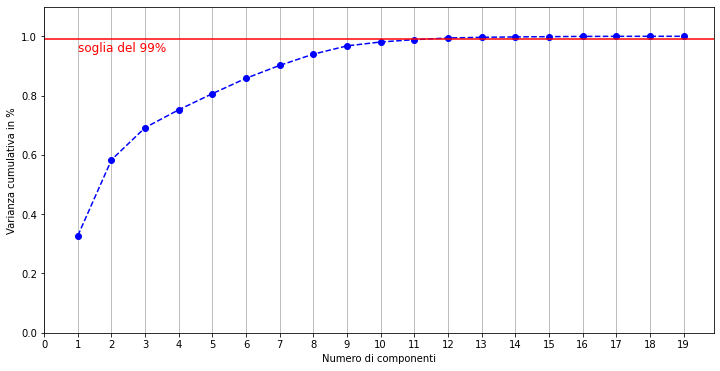

In [12]:
pca = PCA().fit(train_x_scaled)

fig, ax = plt.subplots()
xi = np.arange(1, 20, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Numero di componenti')
plt.xticks(np.arange(0, 20, step=1))
plt.ylabel('Varianza cumulativa in %')

plt.axhline(y=0.99, color='red')
plt.text(1, 0.95, 'soglia del 99%', color = 'red', fontsize=12)

ax.grid(axis='x')
plt.show()

In [13]:
#PCA

pca = PCA(n_components = 12)
pca.fit(train_x_scaled)

train_x_scaled_PCA = pd.DataFrame(data = pca.transform(train_x_scaled))
test_x_scaled_PCA = pd.DataFrame(data = pca.transform(test_x_scaled))

train_x_scaled_PCA

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.759106,-1.079964,0.628163,1.421957,0.000958,-0.590690,-0.887366,0.287899,0.183560,0.014355,0.043929,-0.065721
1,-3.403953,-0.652652,0.816588,0.978481,0.255928,-0.629116,-0.385492,-1.125231,0.240132,-0.497264,-0.358011,0.178551
2,6.919611,5.720729,0.568899,-0.721639,0.323298,0.325908,-0.746393,-0.669812,-2.326539,-0.358542,2.048394,-0.038148
3,-2.081487,-0.793546,0.677158,-1.584977,-0.147396,-0.014785,-0.050078,1.012833,-0.251769,-0.212812,0.471889,-0.176368
4,0.760920,-1.043026,0.526662,-0.605585,-0.050584,-0.264743,0.128165,0.458018,0.063899,0.104091,0.095428,0.037032
...,...,...,...,...,...,...,...,...,...,...,...,...
915,-1.858308,-1.057574,0.896698,-1.938913,0.488341,0.538097,-0.349745,-0.869628,0.533843,0.407548,0.098144,-0.015832
916,-0.479296,0.690222,-1.200707,0.769525,0.511437,0.048153,-0.941019,-0.965259,0.539321,-0.350885,-0.723295,0.590368
917,-0.401821,-1.066851,0.840016,-0.918887,-0.098516,-0.276411,0.178098,0.507790,-0.080790,-0.370474,0.793339,0.182354
918,-2.431054,-1.171682,1.401026,0.752588,-0.132379,-0.468535,-1.078397,0.905275,0.145390,0.234267,0.058134,-0.041634


### TEST PERFORMANCE DATI NORMALIZZATI E APPLICAZIONE PCA

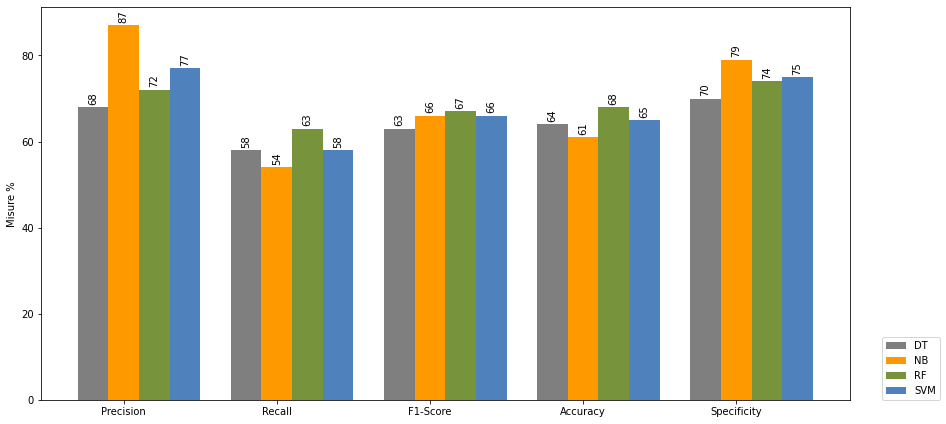

In [14]:
scores = []

for classificatore in classifiers:
    classificatore.fit(train_x_scaled_PCA, y_train)
    y_pred = classificatore.predict(test_x_scaled_PCA)
    
    tp, fp, fn, tn = recuperaPerformance(_y_test, y_pred)
   
    score = []
        
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    f1 = (2*precision*recall)/(precision+recall)
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    specifity = tn/(fp+tn)
    
    score.append(round(precision,2)*100)
    score.append(round(recall,2)*100)
    score.append(round(f1,2)*100)
    score.append(round(accuracy,2)*100)
    score.append(round(specifity,2)*100)
    
    scores.append(score)

plotPerformance(scores)

### TEST PERFORMANCE DATI NORMALIZZATI, APPLICAZIONE PCA E MFO

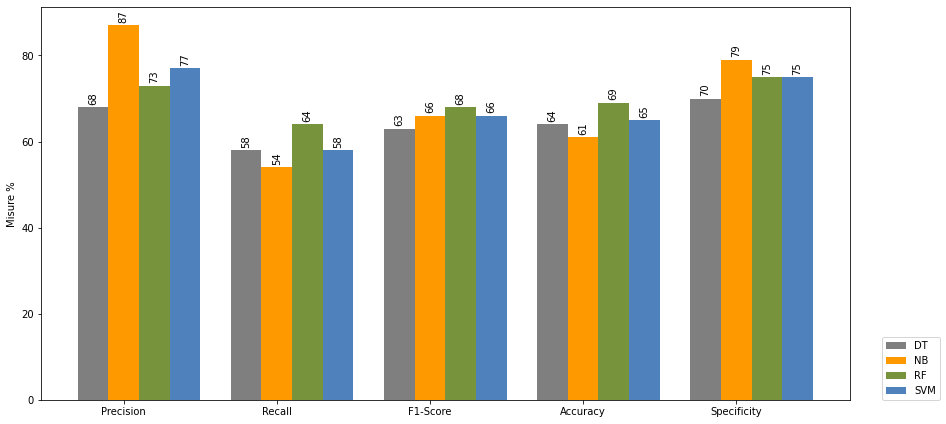

In [15]:
scores = []

for classificatore in classifiers:
    selected_features = mfo(train_x_scaled_PCA, y_train, test_x_scaled_PCA, y_test, 10, classificatore)
    
    x_train_selected_features=pd.DataFrame()
    x_test_selected_features=pd.DataFrame()


    for i in range(len(selected_features)):
        x_train_selected_features[str(selected_features[i])] = train_x_scaled_PCA.iloc[:,int(selected_features[i])]
        x_test_selected_features[str(selected_features[i])] = test_x_scaled_PCA.iloc[:,int(selected_features[i])]
        
    classificatore.fit(train_x_scaled_PCA, y_train)
    y_pred = classificatore.predict(test_x_scaled_PCA)
    
    tp, fp, fn, tn = recuperaPerformance(_y_test, y_pred)
  
    score = []
    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    f1 = (2*precision*recall)/(precision+recall)
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    specifity = tn/(fp+tn)
    
    score.append(round(precision,2)*100)
    score.append(round(recall,2)*100)
    score.append(round(f1,2)*100)
    score.append(round(accuracy,2)*100)
    score.append(round(specifity,2)*100)
    
    scores.append(score)

plotPerformance(scores)

### TEST PERFORMANCE ENSEMBLE DEI CLASSIFICATORI NORMALIZZAZIONE E PCA

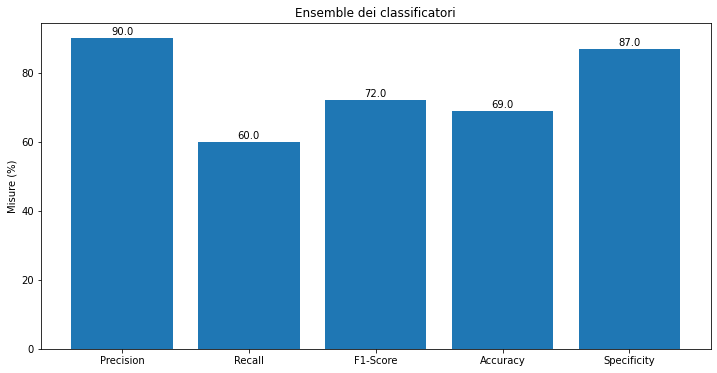

In [16]:
for classificatore in classifiers:
    classificatore.fit(train_x_scaled_PCA, y_train)
    
estimators=[('decisionTree', decisionTree), ('naiveBayes', naiveBayes), ('randomForest', randomForest), ('supportVectorMachine', supportVectorMachine)]
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(train_x_scaled_PCA, y_train)
y_pred = ensemble.predict(test_x_scaled_PCA)

    
tp, fp, fn, tn = recuperaPerformance(_y_test, y_pred)
  
score = []
    
precision = tp/(fp+tp)
recall = tp/(fn+tp)
f1 = (2*precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tn+fp+fn+tp)
specifity = tn/(fp+tn)

score.append(round(precision,2)*100)
score.append(round(recall,2)*100)
score.append(round(f1,2)*100)
score.append(round(accuracy,2)*100)
score.append(round(specifity,2)*100)


labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Specificity']
plt.bar(labels, score)      
for i in range(len(labels)):
    plt.text(i, score[i]+1, score[i], ha = 'center')
    
plt.title("Ensemble dei classificatori")
      
plt.ylabel('Misure ' + '('+'%'+')')
      
plt.show()